In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("../../1. Classification of Myopic Maculopathy/Images/")
path_images = path/"TrainingSet"
path_labels = path/"Choroidal"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("TrainingSet","Choroidal"))

In [7]:
codes = ['BG','FG']

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),ShiftScaleRotate(),OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

../../1. Classification of Myopic Maculopathy/Images/TrainingSet/mmac_task_1_train_0549.png


<Axes: >

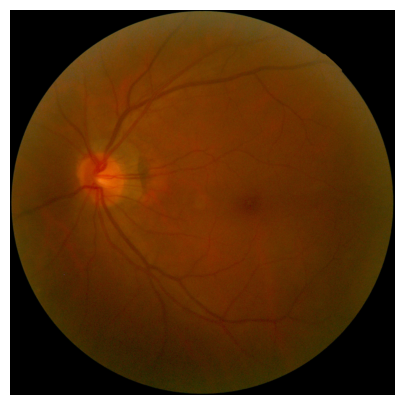

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

../../1. Classification of Myopic Maculopathy/Images/Choroidal/mmac_task_1_train_0549.png


In [15]:
# mask = PILMask.create(get_y_fn(img_f))
# mask.show(figsize=(5, 5), alpha=1)

In [16]:
bs = 4

In [17]:
codes

['BG', 'FG']

In [18]:
def my_get_image_files(path):
    return [Path(str(x).replace('Choroidal','TrainingSet')) for x in get_image_files(path)]

In [19]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=my_get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

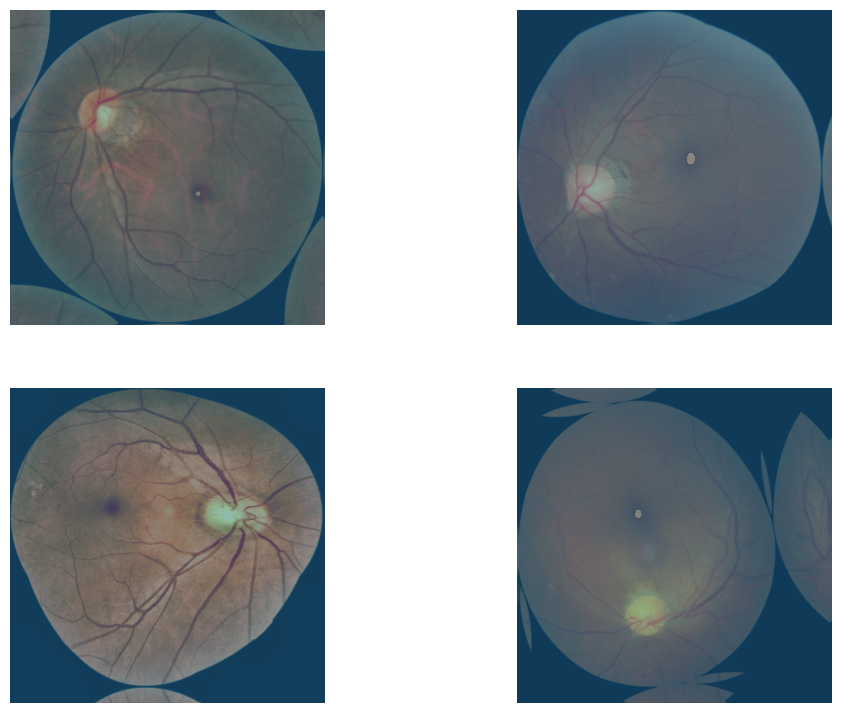

In [20]:
dlsTrain = trainDB.dataloaders(path_labels,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [22]:
learn = Learner(dlsTrain,model,metrics=[DiceMulti()],loss_func=FocalLossFlat(axis=1)).to_fp16()

epoch,train_loss,valid_loss,dice_multi,time
0,0.060250,0.034604,0.500991,00:22
1,0.032250,0.015381,0.500037,00:21
2,0.018549,0.008694,0.515734,00:21
3,0.011083,0.004912,0.520829,00:21
4,0.006773,0.003205,0.500332,00:21
5,0.004165,0.002259,0.499712,00:21
6,0.002717,0.001730,0.499685,00:21
7,0.001917,0.001403,0.499685,00:21
8,0.001467,0.001479,0.499685,00:22
9,0.001138,0.000959,0.499685,00:21


Better model found at epoch 0 with dice_multi value: 0.5009913694270962.


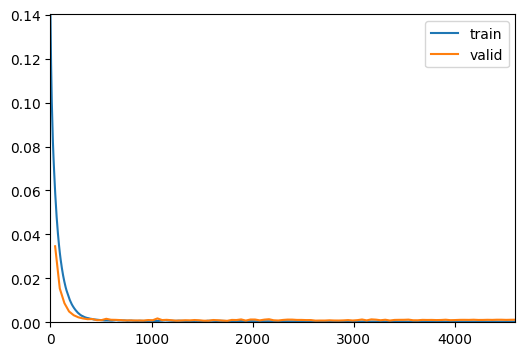

Better model found at epoch 2 with dice_multi value: 0.5157341225455421.
Better model found at epoch 3 with dice_multi value: 0.5208291043216561.
Better model found at epoch 11 with dice_multi value: 0.6816700557209807.
Better model found at epoch 14 with dice_multi value: 0.7069236545545758.
Better model found at epoch 15 with dice_multi value: 0.785271661741051.
Better model found at epoch 18 with dice_multi value: 0.7907417676396595.
Better model found at epoch 25 with dice_multi value: 0.7927001886225722.
Better model found at epoch 26 with dice_multi value: 0.8111127568650796.
Better model found at epoch 61 with dice_multi value: 0.8121110092130039.
Better model found at epoch 70 with dice_multi value: 0.8189661943154529.


In [23]:
fname="unetplusplus-resnet50-semi"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [24]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [25]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [26]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

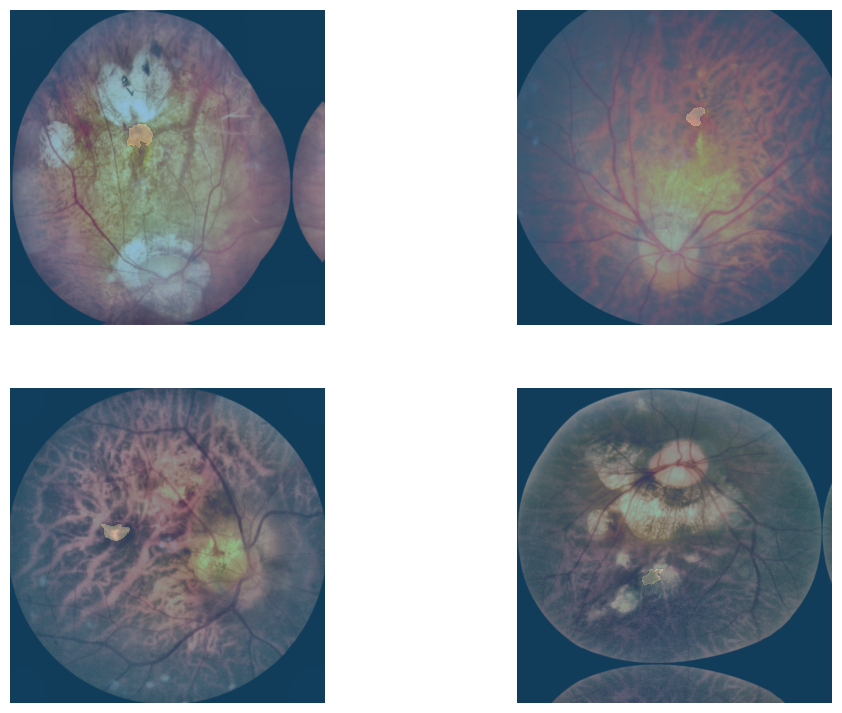

In [27]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [28]:
learn.dls = dlsTrain

epoch,train_loss,valid_loss,dice_multi,time
0,0.003620,0.003528,0.692494,00:04
1,0.002817,0.002966,0.736159,00:04
2,0.002630,0.002567,0.756289,00:04
3,0.002475,0.002182,0.777191,00:04
4,0.002267,0.001957,0.785213,00:04
5,0.002101,0.001903,0.773940,00:04
6,0.002018,0.001938,0.737025,00:04
7,0.001932,0.002010,0.693957,00:04
8,0.001825,0.002222,0.668904,00:04
9,0.001800,0.002322,0.691491,00:04


Better model found at epoch 0 with dice_multi value: 0.6924943525207128.


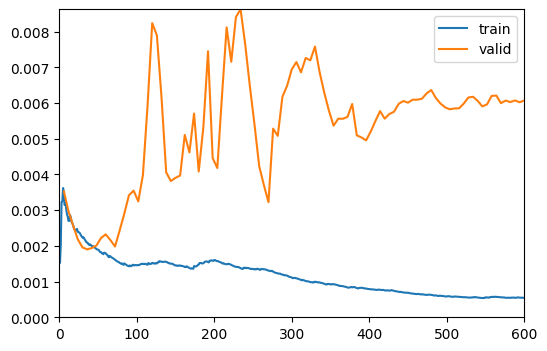

Better model found at epoch 1 with dice_multi value: 0.7361593502302723.
Better model found at epoch 2 with dice_multi value: 0.7562893547600028.
Better model found at epoch 3 with dice_multi value: 0.7771913720038272.
Better model found at epoch 4 with dice_multi value: 0.7852126444474798.
Better model found at epoch 11 with dice_multi value: 0.7914166673483651.


In [29]:
fname="unetplusplus-resnet50-semi-v2"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [30]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'unetplusplus-choroidal-semi.pth')